**Python (Semester 2 2024)**
# 8 Astronomical Packages

*N. Hernitschek*

This notebook contains example of analyzing astronomical data with advanced Python packages as part of **Python (Semester 2 2024)**. 

---
## Contents

* [Catalog cross-matching](#first-bullet)
* [Using photutils](#second-bullet)
* [Summary](#third-bullet)


In [ ]:

## Imports

We start with some imports:

In [45]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord



# Third-party dependencies
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table
import numpy as np
from IPython.display import Image

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 13

## 1. Catalog cross-matching <a class="anchor" id="first-bullet"></a>


`astropy.coordinates` contains commonly-used tools for comparing or matching coordinate objects. It supports leverages the coordinate framework to make it straightforward to find the closest coordinates in a catalog to a desired set of other coordinates.




In [32]:
! pip3 install tabulate

Defaulting to user installation because normal site-packages is not writeable


HCG 7 is a compact configuration of four (three late-type and one lenticular) galaxies. Its center coordinates are as follows:

In [35]:
SkyCoord('0h39m15.9s', '0d53m17.016s', frame='icrs')


<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>



If the object you're interested in is in SESAME, you can also look it up directly from its name using the `SkyCoord.from_name()` class method:

In [62]:
hcg7_center = SkyCoord.from_name('HCG 7')
hcg7_center

<SkyCoord (ICRS): (ra, dec) in deg
    (9.81625, 0.88806)>


The `SkyCoord` object we just created has various useful ways of accessing the information contained within it. In particular, the `ra` and `dec` attributes are specialized `Quantity` objects storing angles. They provide useful representations of those angles, as well as some useful attributes to quickly convert to common angle units:


In [37]:
hcg7_center.dec

<Latitude 0.88806 deg>

In [38]:
type(hcg7_center.ra)

astropy.coordinates.angles.Longitude

### Retrieving astronomical images from SDSS image cutout service

Now that we have a `SkyCoord` object, we can try to use it to access data from the Sloan Digitial Sky Survey (SDSS).

We start with retrieving an image using the SDSS image cutout service. We do this to make sure HCG7 is in the SDSS footprint and has good image quality.

In [40]:
from urllib.parse import urlencode
from urllib.request import urlretrieve

impix = 1024
imsize = 12*u.arcmin
cutoutbaseurl = 'http://skyservice.pha.jhu.edu/DR12/ImgCutout/getjpeg.aspx'
query_string = urlencode(dict(ra=hcg7_center.ra.deg, 
                              dec=hcg7_center.dec.deg, 
                              width=impix, height=impix, 
                              scale=imsize.to(u.arcsec).value/impix))
url = cutoutbaseurl + '?' + query_string

# this downloads the image to your disk
urlretrieve(url, 'HCG7_SDSS_cutout.jpg')



('HCG7_SDSS_cutout.jpg', <http.client.HTTPMessage at 0x70bec5bada20>)

### Retrieving SDSS photometry

We can now retrieve the photometry and write it to a table:

In [50]:
from astroquery.sdss import SDSS
sdss = SDSS.query_region(coordinates=hcg7_center, radius=20*u.arcmin, 
                         spectro=True, 
                         photoobj_fields=['ra','dec','u','g','r','i','z'])
print(sdss)
sdss.write('HCG7_SDSS_photo.dat', format='ascii')

       ra               dec           u        g        r        i        z    
---------------- ----------------- -------- -------- -------- -------- --------
9.48301378408814  1.01446279778812 23.51845 22.13895 20.82912 19.92155 19.47135
9.48341569139689 0.976399855054926 22.81118 22.03554 22.10897 22.14101 21.64411
9.48404442918999 0.668844321347565 21.08944 18.71639  17.1889 15.90083 15.19136
9.48407695277552  1.19045532333533 23.89431 22.32235 21.00772 19.96612 19.64056
9.48440312780167  1.16365522098835 21.36359 20.86403 20.86694 20.54494 20.98261
9.48516597211733  1.06970371044418 19.19686  17.4415 16.72897 16.46968 16.34503
9.48663932955685 0.650341053923046 25.78184 22.76056 21.43424 20.43382 19.79225
9.48670915066737 0.571826270065982 21.13963 18.75032 17.70842 17.32286 17.07478
9.48841923342013 0.594765107669862 23.21057 25.03088 21.79477 20.54489 19.51502
9.48888650786188  1.06993015820522 20.24263 19.56245 19.23878 18.90491 18.89328
             ...               ...      

OSError: File HCG7_SDSS_photo.dat already exists. If you mean to replace it then use the argument "overwrite=True".

### Catalog cross-matching

With that, we have a catalog of objects we got from the SDSS. Now lets say you have your own catalog of objects in the same field that you want to match to this SDSS catalog. 

For doing so, as a second catalog we will use a catalog extracted from the 2MASS. We first load it from an ascii file

In [52]:
twomass = Table.read('HCG7_2MASS.tbl', format='ascii')



To carry out the cross-match, we need `SkyCoord` objects. 
To create them from the tables we have, we use the `ra` and `dec`columns and provide them to the `SkyCoord` constructor. 


We first take a look at the content of the tables:

In [53]:
sdss # just to see an example of the format


ra,dec,u,g,r,i,z
float64,float64,float64,float64,float64,float64,float64
9.48301378408814,1.01446279778812,23.51845,22.13895,20.82912,19.92155,19.47135
9.48341569139689,0.976399855054926,22.81118,22.03554,22.10897,22.14101,21.64411
9.48404442918999,0.668844321347565,21.08944,18.71639,17.1889,15.90083,15.19136
9.48407695277552,1.19045532333533,23.89431,22.32235,21.00772,19.96612,19.64056
9.48440312780167,1.16365522098835,21.36359,20.86403,20.86694,20.54494,20.98261
9.48516597211733,1.06970371044418,19.19686,17.4415,16.72897,16.46968,16.34503
9.48663932955685,0.650341053923046,25.78184,22.76056,21.43424,20.43382,19.79225
9.48670915066737,0.571826270065982,21.13963,18.75032,17.70842,17.32286,17.07478
9.48841923342013,0.594765107669862,23.21057,25.03088,21.79477,20.54489,19.51502


In [54]:
twomass # just to see an example of the format

designation,ra,dec,r_k20fe,j_m_k20fe,j_msig_k20fe,j_flg_k20fe,h_m_k20fe,h_msig_k20fe,h_flg_k20fe,k_m_k20fe,k_msig_k20fe,k_flg_k20fe,k_ba,k_phi,sup_ba,sup_phi,r_ext,j_m_ext,j_msig_ext,h_m_ext,h_msig_ext,k_m_ext,k_msig_ext,cc_flg,dist,angle
,deg,deg,arcsec,mag,mag,,mag,mag,,mag,mag,,,deg,,deg,arcsec,mag,mag,mag,mag,mag,mag,,arcsec,deg
str16,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,str1,float64,float64
00402069+0052508,10.086218,0.880798,9.4,13.835,0.068,0,13.01,0.086,0,12.588,0.089,0,0.8,70,0.82,35,18.62,13.632,0.088,12.744,0.104,12.398,0.105,0,972.120611,91.538952
00395984+0103545,9.99935,1.06514,12.9,12.925,0.035,0,12.183,0.042,0,11.89,0.067,0,0.8,35,0.7,40,35.9,12.469,0.048,11.91,0.066,11.522,0.087,0,916.927636,45.951861
00401849+0049448,10.077062,0.82913,6.0,14.918,0.086,0,14.113,0.107,0,13.714,0.103,0,0.6,-15,1.0,90,11.35,14.631,0.121,13.953,0.169,13.525,0.161,0,962.489231,102.73149
00395277+0057124,9.969907,0.953472,5.3,14.702,0.049,0,14.248,0.069,0,13.899,0.095,0,0.6,-60,0.44,-50,10.59,14.62,0.144,14.15,0.296,13.73,0.2,0,601.136444,66.93659
00401864+0047245,10.077704,0.790143,7.6,15.585,0.134,1,15.003,0.18,1,14.049,0.142,1,0.5,30,0.46,30,14.48,14.977,0.138,14.855,0.303,13.653,0.18,0,1004.982128,110.53147
00393485+0051355,9.895219,0.859882,39.3,11.415,0.031,3,10.755,0.044,3,10.514,0.068,3,0.6,-30,0.7,-60,92.29,11.415,0.018,10.155,0.054,9.976,0.085,0,301.813395,109.639102
00392964+0103495,9.873526,1.063769,10.9,14.463,0.065,0,13.618,0.067,0,13.258,0.091,0,0.4,55,0.28,60,20.35,14.2,0.086,13.363,0.091,13.101,0.133,0,665.301415,18.051526
00403343+0049079,10.139293,0.818865,5.0,15.484,0.15,0,--,--,--,13.97,0.137,0,1.0,90,1.0,90,10.05,15.035,0.183,14.725,0.0,13.654,0.189,0,1189.207905,102.088788


We see that in both of them, `ra` and `dec`columns are present.

We now create the `SkyCoord` objects:

In [55]:
coo_sdss = SkyCoord(sdss['ra']*u.deg, sdss['dec']*u.deg)
coo_twomass = SkyCoord(twomass['ra'], twomass['dec'])




Note a subtle difference here: you had to give units for SDSS but not for 2MASS. This is because the 2MASS table has units associated with the columns, while the SDSS table does not (so you have to put them in manually).

Now we simply use the `SkyCoord.match_to_catalog_sky` method to match the two catalogs. Note that order matters: 
we're matching 2MASS to SDSS because there are many more entires in the SDSS, so it seems likely that most 2MASS objects are in SDSS (but not vice versa).


In [56]:
idx_sdss, d2d_sdss, d3d_sdss = coo_twomass.match_to_catalog_sky(coo_sdss)

`idx_sdss` are the indices into `coo_sdss` that get the closest matches, while `d2d_sdss` and `d3d_sdss` are the on-sky and real-space distances between the matches. In our case, `d3d_sdss` can be ignored because we didn't give a line-of-sight distance, so its value is not particularly useful. But `d2d_sdss` provides a good diagnosis of whether we actually have real matches:

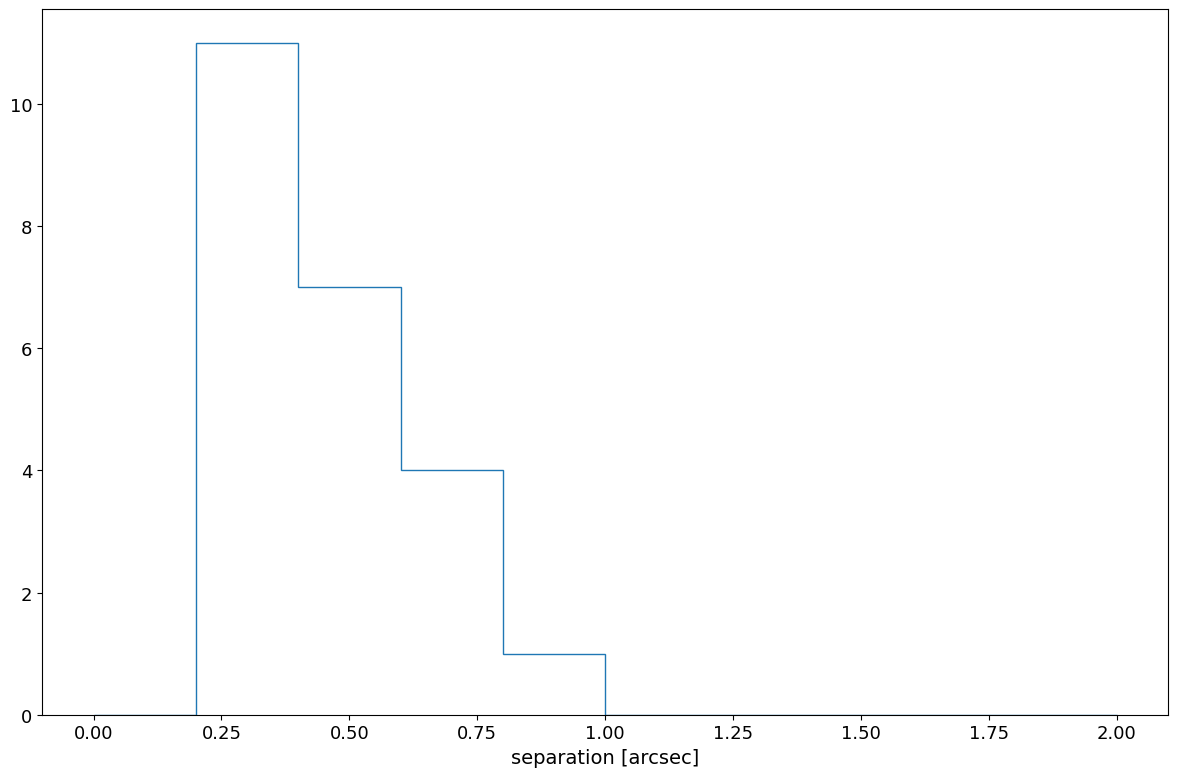

In [57]:

plt.hist(d2d_sdss.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.tight_layout()


We see that all cross-matches are within an arcsecond. But we can't be sure yet that they are indeed matched to the correct source and not any other nearby source.

Let's check this by comparing to a set of random points.

We first create a set of uniformly random points (with size matching coo_twomass) that cover the same range of RA/Decs that are in `coo_sdss`.


In [58]:
ras_sim = np.random.rand(len(coo_twomass))*coo_sdss.ra.ptp() + coo_sdss.ra.min()
decs_sim = np.random.rand(len(coo_twomass))*coo_sdss.dec.ptp() + coo_sdss.dec.min()
ras_sim, decs_sim


(<Angle [ 9.75976566, 10.03856336, 10.00875824,  9.62793043,  9.80596563,
          9.52059927,  9.64482212,  9.5509274 , 10.1083726 ,  9.71202235,
          9.64393405,  9.61430712, 10.02445091,  9.85990268,  9.50667277,
         10.12110846,  9.86977266,  9.94152432,  9.5507073 ,  9.7341492 ,
          9.93777901,  9.49488811,  9.95664675] deg>,
 <Angle [1.21147237, 0.55510678, 0.8213538 , 0.95458622, 0.73299429,
         0.70629172, 0.82604656, 0.66503732, 0.86800492, 1.03740901,
         0.87202067, 0.78686334, 0.57429226, 0.98257199, 0.91438895,
         1.15560392, 0.76313809, 0.65864376, 0.6896265 , 1.06262286,
         1.08661011, 1.02846646, 0.59251358] deg>)

Now we create a `SkyCoord from these points and match it to `coo_sdss` just like we did above for 2MASS.

Note that we do not need to explicitly specify units for `ras_sim` and `decs_sim? as they are already `Angle`objects  because they were created from `coo_sdss.ra` and `coo_sdss.dec`.


In [59]:
coo_simulated = SkyCoord(ras_sim, decs_sim)  
idx_sim, d2d_sim, d3d_sim = coo_simulated.match_to_catalog_sky(coo_sdss)


We now plot the histogram of separations from our simulated catalog, so we can compare to the above results from the real catalog.


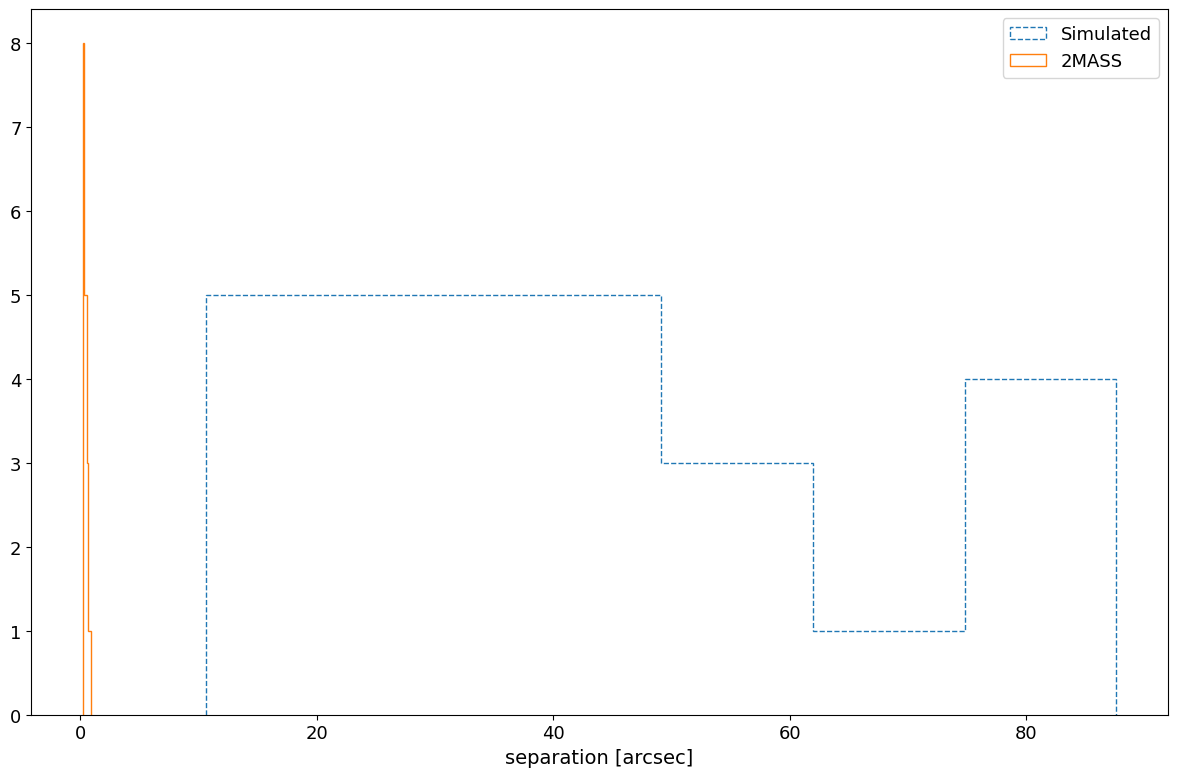

In [60]:

plt.hist(d2d_sim.arcsec, bins='auto', histtype='step', label='Simulated', linestyle='dashed')
plt.hist(d2d_sdss.arcsec, bins='auto', histtype='step', label='2MASS')
plt.xlabel('separation [arcsec]')
plt.legend(loc=0)
plt.tight_layout()


What do we see from this?


It looks like randomly placed sources should be more like an arcminute away, so we can probably trust that our earlier matches which were within an arcsecond are valid. 


With that in mind, we can start computing things like colors that combine the SDSS and 2MASS photometry.


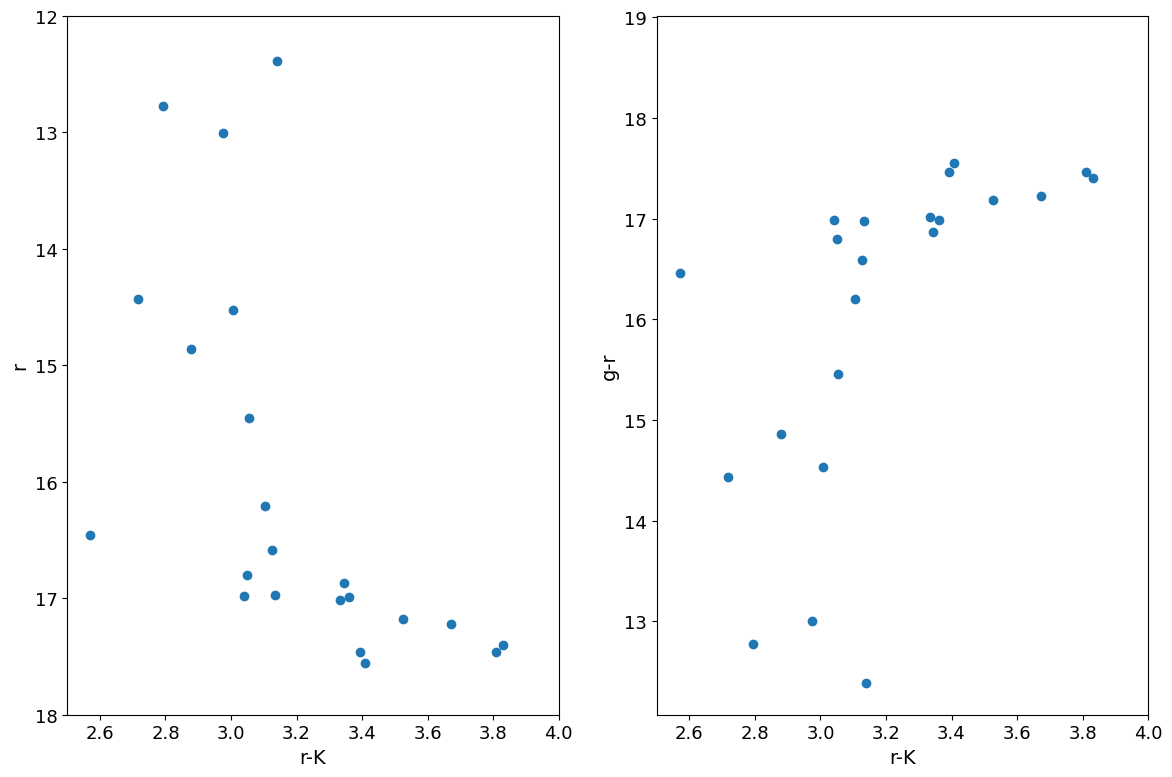

In [61]:
rmag = sdss['r'][idx_sdss]
grcolor = sdss['g'][idx_sdss] - rmag
rKcolor = rmag - twomass['k_m_ext']

plt.subplot(1, 2, 1)
plt.scatter(rKcolor, rmag)
plt.xlabel('r-K')
plt.ylabel('r')
plt.xlim(2.5, 4)
plt.ylim(18, 12)


plt.subplot(1, 2, 2)
plt.scatter(rKcolor, rmag)
plt.xlabel('r-K')
plt.ylabel('g-r')
plt.xlim(2.5, 4)

plt.tight_layout()

## 2. Using `photutils` <a class="anchor" id="second-bullet"></a>

Photutils is an affiliated package of Astropy to provide tools for detecting and performing photometry of astronomical sources.

It contains a variety of tools, out of which we will use here:

*    Background Estimation (photutils.background)
*    Source Detection (photutils.detection)
*    Aperture Photometry (photutils.aperture)


### Installing `photutils`

You might need to install `photutils` first:

In [10]:
! pip3 install photutils

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.3 MB/s eta 0:00:00


### Plotting Photometry

As we will be using the image visualization several times, let's make a function that makes our code cleaner:


In [2]:
from astropy.visualization import ZScaleInterval

def my_python_ds9(data):
    norm = ZScaleInterval()
    vmin, vmax = norm.get_limits(data)
    plt.imshow(data, vmin=vmin, vmax=vmax, interpolation='none', origin='lower')
    plt.colorbar()




Before performing any photometry we need to have a first guess of the image background properties. For this section we will use an optical image from the Sloan Digital Sky Survey (SDSS). This image contains the Spindle Galaxy, also known as Messier 102 or NGC 5866.


In [3]:
sdss_g_hdu_list = fits.open('sdss_g.fits')
sdss_g_hdu_list.info()


Filename: sdss_g.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


We can plot the photometry:

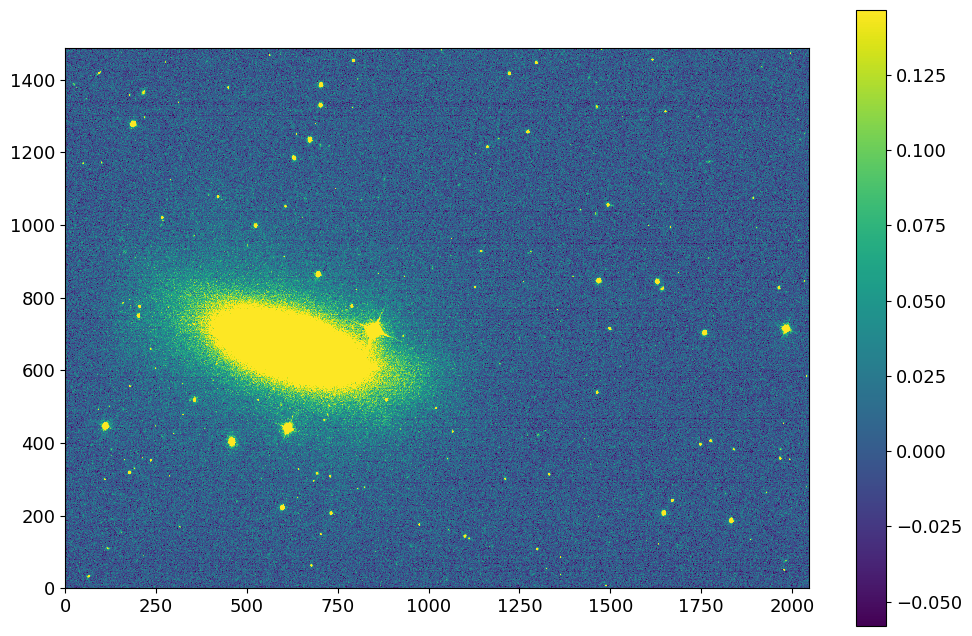

In [4]:
my_python_ds9(sdss_g_hdu_list[0].data)

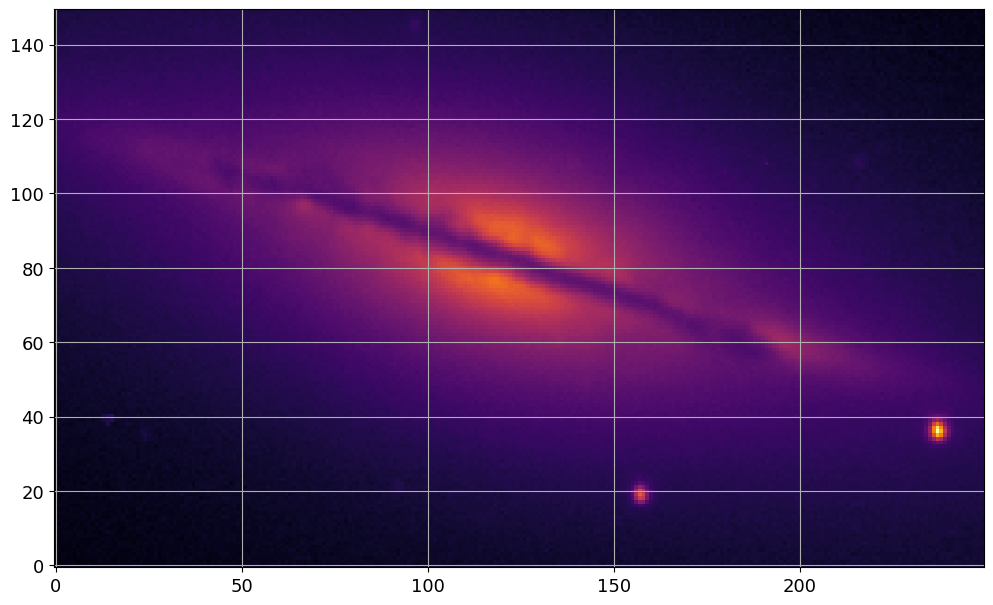

In [5]:
plt.imshow(np.power(sdss_g_hdu_list[0].data[580:730, 500:750], 0.5), cmap='inferno', origin='lower')
plt.grid('off')

### Statistics



Let's get the basic statistics of it. For that we will need to remove the sources using a sigma clipping routine:


In [7]:
from astropy.stats import sigma_clipped_stats

mean, median, std = sigma_clipped_stats(sdss_g_hdu_list[0].data, sigma=3.0)    
print((mean, median, std))    


(0.0051070782, 0.004753113, 0.022115234)




We will need also the pixel scale that we can retrieve from the WCS:


In [8]:
from astropy import wcs

sdss_g_image_wcs = wcs.WCS(sdss_g_hdu_list[0].header)
sdss_pixelscale = np.mean(wcs.utils.proj_plane_pixel_scales(sdss_g_image_wcs) * u.degree).to('arcsec')
sdss_pixelscale

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


<Quantity 0.3958432 arcsec>

### Object detection

To detect the sources inside a astronomical image PhotUtils provides DAO Phot implementations to detect


In [15]:
from photutils.detection import DAOStarFinder
sigma_detection = 5.0
fwhm = 1.5 * u.arcsec / sdss_pixelscale
daofind = DAOStarFinder(fwhm=fwhm.value, threshold=sigma_detection*std)    
sources = daofind(sdss_g_hdu_list[0].data - median)    
print(sources)

3.7893791987531147
 id     xcentroid          ycentroid      ...        flux                 mag         
--- ------------------ ------------------ ... ------------------ ---------------------
  1  1486.638864525346  6.300533976629028 ...  3.814560651779175   -1.4536113114967493
  2  1361.937876867555  36.55248087345152 ... 1.8276240825653076   -0.6547171802772829
  3 1976.4566047830601  49.50616579436974 ... 2.9917709827423096   -1.1898208640756458
  4 1322.5223504784926  53.03722289735053 ... 3.3527908325195312    -1.313516150857998
  5  676.8606245948037  61.29755208861998 ...  25.36217498779297    -3.510466236657229
  6  1795.991382458698  70.32024356716214 ... 1.1019880771636963  -0.10544223935196835
  7 1362.1860810499215  83.62137856134737 ...  2.812643051147461   -1.1227865497932776
  8  215.4033023515488  89.00727305824422 ... 1.1251049041748047    -0.127982544296715
  9 1297.7504374295183 106.58694191268008 ... 19.339094161987305    -3.216090319964193
 10  117.1127493520293  

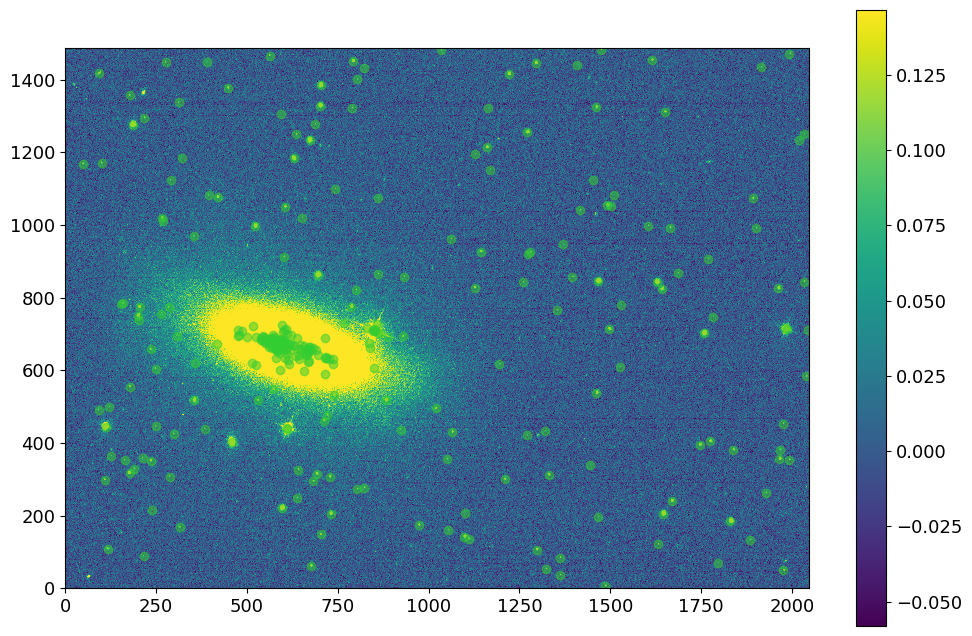

In [16]:
my_python_ds9(sdss_g_hdu_list[0].data)

plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.5, color='limegreen')


## PSF Modelling

We assumed that the image had a typical value of 1.5" per pixel. But we can make a more accurate estimation by fitting the pixels to a moffat profile around a detected star.

First, let's select the source we want to use for PSF modelling:


x pos: 1746.1530254364832
y pos: 395.2076732084301


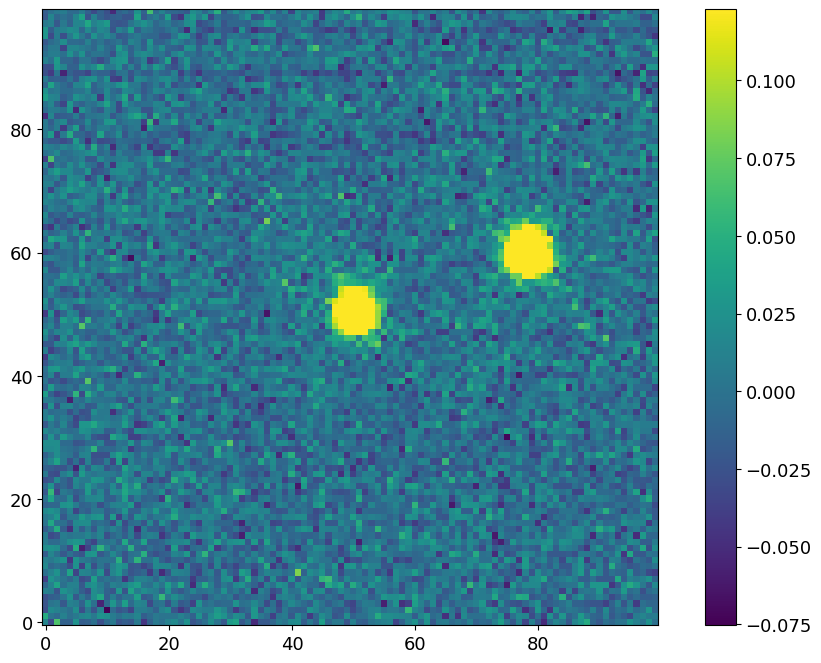

In [17]:
isource = sources[50]

# High SN - 50
# Low SN - 33
# Non-uniform background - 78

print ("x pos: " + str(isource['xcentroid']))
print ("y pos: " + str(isource['ycentroid']))

stamp_radius = 50
my_python_ds9(sdss_g_hdu_list[0].data[int(isource['ycentroid'] - stamp_radius):
                                      int(isource['ycentroid'] + stamp_radius), 
                                      int(isource['xcentroid'] - stamp_radius): 
                                      int(isource['xcentroid'] + stamp_radius)])




As we intend to find the profile of the source, we need to remove the possible sky background that lies behind:


In [18]:
# Median bkg subtracted image
bkg_subtracted_image = sdss_g_hdu_list[0].data - median

# 2D background subtracted - For later
#bkg_subtracted_image = sdss_g_hdu_list[0].data - bkg.background

To simplify the problem, we turn the 2D profile into a 1D distance array from the center of each pixel to the centroid of the source estimated by DAO Phot:

In [19]:
flux_counts = []
pixel_distance = []

x_cen = int(isource['xcentroid'])
y_cen = int(isource['ycentroid'])

# Pixels around detection loop
analysis_radius = 10
for x in range(x_cen - analysis_radius, x_cen + analysis_radius):
    for y in range(y_cen - analysis_radius, y_cen + analysis_radius):
        flux_counts.append(((bkg_subtracted_image[y][x]) / isource['peak']))
        pixel_distance.append(np.linalg.norm((isource['xcentroid'] - x, isource['ycentroid'] - y)))



Here we present two possible models that can fit the PSF distribution. A Gaussian and a Moffat profile:


In [20]:
from astropy.modeling import models, fitting

model = 'moffat'

if model == 'gaussian':
    # Fit the data using a Gaussian
    fwhm_best_guess = 1.5
    model_init = models.Gaussian1D(amplitude=1.0, mean=0, stddev=fwhm_best_guess)
elif model == 'moffat':
    # Fit the data using a Moffat
    model_init = models.Moffat1D(amplitude=1.0, x_0=0, gamma=2., alpha=3.5)
else:
    raise Exception("Unknown model type: %s. Must be gaussian or moffat." % model)

fitter = fitting.SimplexLSQFitter()
fitted_model = fitter(model_init, pixel_distance, flux_counts)

print ("Fit value:",  fitter.fit_info['final_func_val'])
print ("SN:", isource['flux'] * sigma_detection)


Fit value: 0.08707625917033143
SN: 171.5020751953125




Once fitted the models, we need to convert from the parameters to the actual FWHM estimate.


In [21]:
# FHWM conversion
if model == 'gaussian':
    iFWHM = 2.355 * fitted_model.stddev * sdss_pixelscale.value
elif model == 'moffat':
    iFWHM = fitted_model.gamma * 2 * np.sqrt(2 ** (1. / fitted_model.alpha) - 1) * sdss_pixelscale.value
else:
    raise Exception("Unknown model type: %s. Must be gaussian or moffat." % model)

print ("FWHM estimated: ", iFWHM)

FWHM estimated:  1.0888679058411375




We can finally plot and see how the model traces the pixel values traces our fitted model.


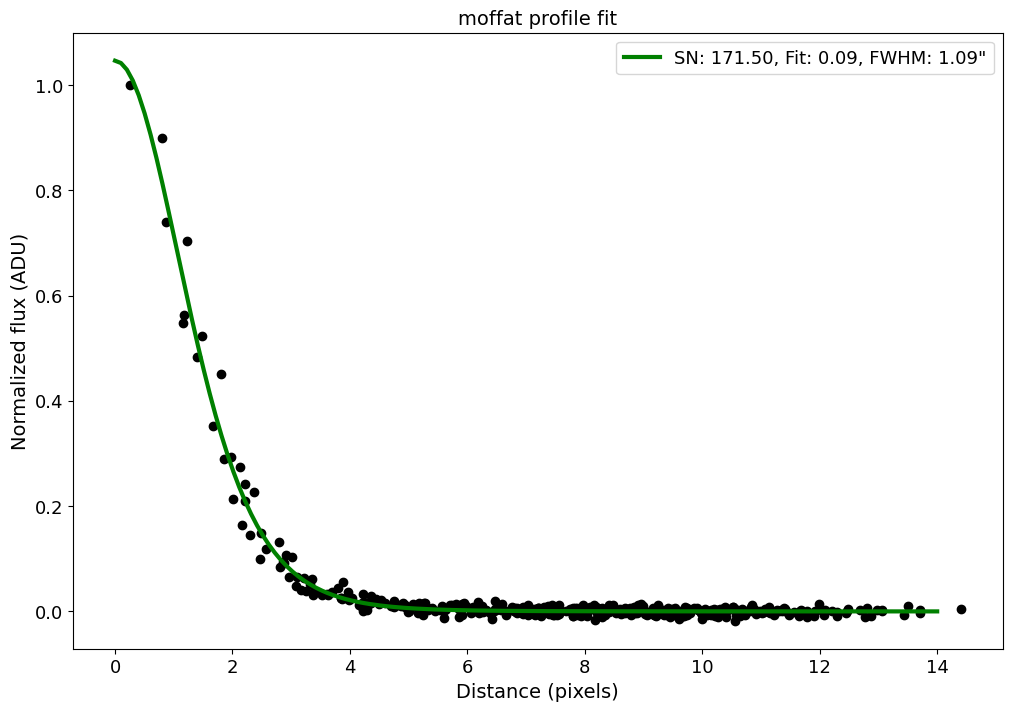

In [22]:
# Check fitting
if fitter.fit_info['final_func_val'] < 5.0:
    color = 'green'
else:
    color = 'red'
    
# Plot the data with the best-fit model
plt.figure()
plt.plot(pixel_distance, flux_counts, 'ko')
rx = np.linspace(0, int(max(pixel_distance)), int(max(pixel_distance)) * 10)
plt.plot(rx,
         fitted_model(rx),
         color=color,
         lw=3.0,
         label='SN: %.2f, Fit: %.2f, FWHM: %.2f"' % (isource['flux'] * sigma_detection,
                                                       fitter.fit_info['final_func_val'],
                                                       iFWHM))
plt.xlabel('Distance (pixels)')
plt.ylabel('Normalized flux (ADU)')
plt.title('%s profile fit' % model)
plt.legend()
plt.show()

### Background Modeling


As we have seen in the case with non-uniform background, the constant median can be insuficient. Here we produce a 2D model of the background that can be subtracted from the original image to improve the modelling of the stars close to a very large extended source (or when the backrgound is not flat for any other reason)


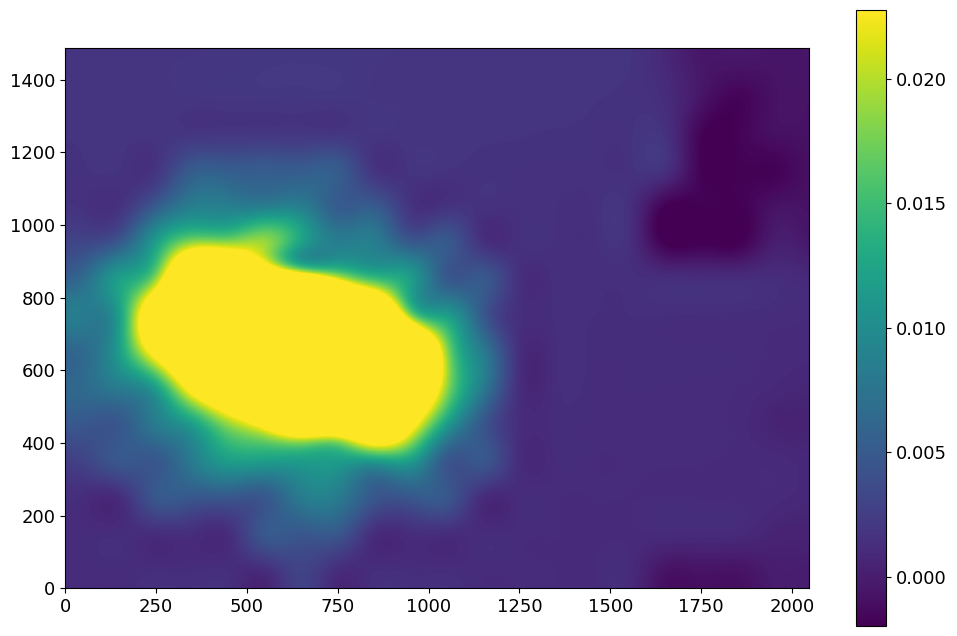

In [27]:
from photutils.background import Background2D, MedianBackground
from astropy.stats import sigma_clipped_stats, SigmaClip


sigma_clip = SigmaClip(sigma=3., maxiters=10)
bkg_estimator = MedianBackground()
bkg = Background2D(data=sdss_g_hdu_list[0].data, 
                   box_size=(100, 100), 
                   filter_size=(3, 3),
                   sigma_clip=sigma_clip, 
                   bkg_estimator=bkg_estimator)
my_python_ds9(bkg.background)



Now let's go back to where the background was subtracted to verify the difference.


## Aperture photometry

Despite not covered in this Jupyter notebook, `photutils` also provides functionality for carrying out aperture photometry. If you work such data, it is a good idea to check this out on your own using the `photutils` documentation.

## Summary <a class="anchor" id="third-bullet"></a>

In this lesson, we saw various ways of how to make use of specialized packages to work with astronomical observation data. Those examples are quite typical for what we encounter when working on research problems, like being able to cross-match catalogs to supplement our data with photometry in other wavebands.

As it's only possible to show a limited overview of some applications here, it is strongly recommended to take a look at the documentaion of the Python libraries presented here to know which functionality exists in case you need it.
